# DS7331 Project 3
#### Group 2: Hollie Gardner, Cleveland Johnson, Shelby Provost
[Dataset Source](https://archive-beta.ics.uci.edu/ml/datasets/census+income)<br/>
[Github Repo](https://github.com/ShelbyP27/DS7331-Project)

## Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
import sklearn as sk

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

#prediction models
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier

# association rules mining
# https://mhahsler.github.io/arules/docs/python/arules_python.html
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

arules = importr("arules")
arulesViz = importr("arulesViz")

import time
%matplotlib inline

%load_ext rmagic
%load_ext rpy2.ipython 

# cluster analysis
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


## Data Preparation

### Loading and Prepping Data 


In [2]:
# Importing the census dataset using pandas
# Reading the CSV file after converting file to csv and removing superfluous spaces via Excel.
df = pd.read_csv('https://raw.githubusercontent.com/ShelbyP27/DS7331-Project/main/adult-data.csv')
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#Cleaning up dataset by removing na values & creating one-hot response
df = df.replace(to_replace='?',value=np.nan) # replace '?' with NaN (not a number)
df.dropna(inplace=True) # Removing na values
df.duplicated(subset=None, keep='first') #Remove duplicates

#change value for income to include non-mathematic notation
df['income'] = df['income'].replace(['<=50K'],'under50K')
df['income'] = df['income'].replace(['>50K'],'over50K')


In [4]:
#remove attributes
del df['education-num']
del df['fnlwgt']
del df['capital-gain']
del df['capital-loss']

#create categorical groups out of continuous
#change age to age_group
age_group = pd.cut(df.age,bins=[12,19,34,65,120], labels=['teenager','early adult','adult','older adult'])
df.insert(2,'agegroup',age_group)
del df['age']

#change hours-per-week to 
hours_group = pd.cut(df['hours-per-week'], bins=[0,30,40,168], labels=['part-time','full-time','over-time'])
df.insert(9,'hoursgroup',hours_group)
del df['hours-per-week']



## Business Understanding
*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

The purpose of the dataset selected is to identify what characteristics an individual needs to possess in order to make an income exceeding $50,000. Since we've chosen to analyze using association rule mining, then measurements of effectiveness will be lift and [insert here] when we filter to our question of interest of whether income is greater or less than $50k is on the right hand side. The algorithm must also not be a burden computational, therefore we will adjust our confidence and support requirements. The length of itemlists on the left-hand-side will ideally be greater than 1. 

We have chosen to use the association rule mining by treating each individual and their characteristics as a transaction. The "item lists", or characteristics of the individuals within this dataset, will hopefully accomplish the task of understanding what are the most important characteristics that determine whether someone in the 1990s United States would have had an income that exceed $50k. With association rule mining, we understand that there is no implication of causality, but instead this characteristics co-occur. Even still, knowing this information could assist in targeted support for families that had less than $50k and figuring out what interventions could be used to bring families out of poverty levels and into liveable income. 




## Data Understanding
### Part One
*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

The final dataset that will be used for the association rule minging of individuals with an income greater than 50k includes the following 10 attributes: 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   workclass       30162 non-null  object  
 1   agegroup        30162 non-null  category
 2   education       30162 non-null  object  
 3   marital-status  30162 non-null  object  
 4   occupation      30162 non-null  object  
 5   relationship    30162 non-null  object  
 6   race            30162 non-null  object  
 7   sex             30162 non-null  object  
 8   hoursgroup      30162 non-null  category
 9   native-country  30162 non-null  object  
 10  income          30162 non-null  object  
dtypes: category(2), object(9)
memory usage: 2.4+ MB


All of the continuous variables have either been removed or converted into categorical groups for easier identification in the transaction lists. 

According to the Kohavi and Becker, the following changes have already been made to the raw data:
* Discretized agrossincome into two ranges with threshold 50,000.
* Convert U.S. to US to avoid periods.
* Convert Unknown to "?"
* Run MLC++ GenCVFiles to generate data,test.
<br>

Therefore, we began by looking for the '?' values in the dataset by counting the number in each column. Then, we replaced as null using numpy. We decided to handle missing values in the following three variables which possessed missing values as below: 

* Workclass: 1836 rows
* Occupation: 1843 rows
* Native-Country: 583 rows

There was not a way to impute values for these categorical variables and leaving as unknown variables does not add value to our analysis. Therefore, these rows were removed leaving us with 30,162 complete rows in this dataframe. As for duplicates, Kohavi and Becker described 6 duplicate rows. After reviewing our current dataframe, there do not appear to be any instances of duplicate data.


### Part Two
*Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

Initial visual assessment led us to identify 7 attributes that could be important in terms of identifying whether income is greater than or less than $50k. The 7 attributes were comprised of 3 numeric (Age, Education-Num, Hours-per-week) and 4 categorical (Marital Status, Relationship, Race and Sex). Further analysis, with the use of one-hot-coded predictor variables, provided further insight into the variables that are important in predicting whether income is greater than or less that \$50k. An initial logistic regression model proposed the following variables as important features: Age, Hours-per-week, Capital Loss, Education-Num, Marital-Never-married, Marital-married-civ-spouse, Work-private, Rel-husband, Capital Gain, and Rel-not-in-family. A simplified logistic regression model proposed these variables as important features: Age, Capital Loss, and Marital-married-civ-spouse.

While Race and Sex had visual differences in whether income was greater than or less than \$50k and each of them are visulaized below.

**Age:** This age histrogram is subsetting for the reponse variable, income. The histogram shows the right skew of the \<=$50k histogram and the relative normalcy of the \>$50k historgram. The initial logistic regression found that if the age of an individual increases by one unit, the esimated odds of having an income greater than \$50k change by a factor of 0.99. In other words, the odds decrease by 1%.

In [6]:
#Making a new dataframe for graphical purposes
df_graph = pd.read_csv('https://raw.githubusercontent.com/ShelbyP27/DS7331-Project/main/adult-data.csv')

#Cleaning up dataset by removing na values & creating one-hot response
df_graph = df_graph.replace(to_replace='?',value=np.nan) # replace '?' with NaN (not a number)
df_graph.dropna(inplace=True) # Removing na values
df_graph.duplicated(subset=None, keep='first') #Remove duplicates

#change value for income to include non-mathematic notation
df_graph['income'] = df_graph['income'].replace(['<=50K'],'under50K')
df_graph['income'] = df_graph['income'].replace(['>50K'],'over50K')
df_graph['income'] = df_graph['income'].map({'under50K': 0, 'over50K': 1}).astype(int)

#remove attributes
del df_graph['education-num']
del df_graph['fnlwgt']
del df_graph['capital-gain']
del df_graph['capital-loss']

#create categorical groups out of continuous
#change age to age_group
age_group = pd.cut(df_graph.age,bins=[12,19,34,65,120], labels=['teenager','early adult','adult','older adult'])
df_graph.insert(2,'agegroup',age_group)


#change hours-per-week to 
hours_group = pd.cut(df_graph['hours-per-week'], bins=[0,30,40,168], labels=['part-time','full-time','over-time'])
df_graph.insert(9,'hoursgroup',hours_group)



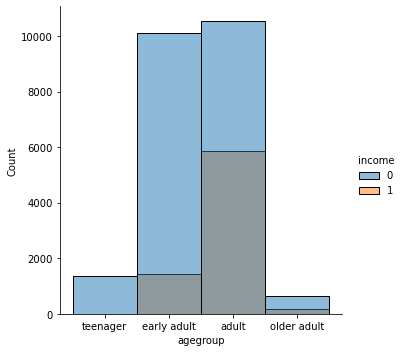

In [7]:
sns.displot(df_graph,x="agegroup",hue="income")

**Education-Num:** This histogram demonstrates a very low number of occurrences for income \>$50k prior to 9 years. The ratios between greater than and less than \$50k begin to flip as the numbers increase from 9.

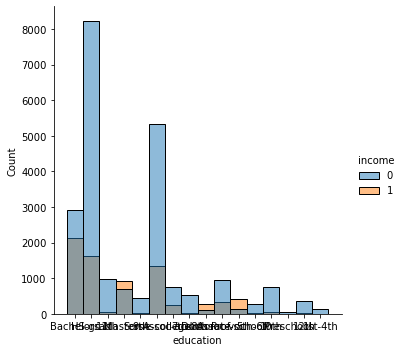

In [8]:
sns.displot(df_graph,x="education", discrete=True,hue="income")

**Hours-Per-Week:** A Kernel density estimation plot was used to make the hours-per-week attribute more easily readable. The choice becomes obvious when compared to the histogram below. The histogram is quite difficult to read due to the high smapling rate at the 40 hours per week. While the Kernel Denity does not provide an accurate count, it does help showcase the greater than \$50k curve that is near zero prior to 40 hours per week adn then tapers to somewhere between 60 and 80 hours per week. The ratio between geater than and less than \$50k increases as the curve tapers to the right.

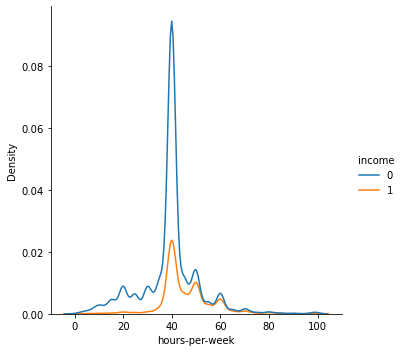

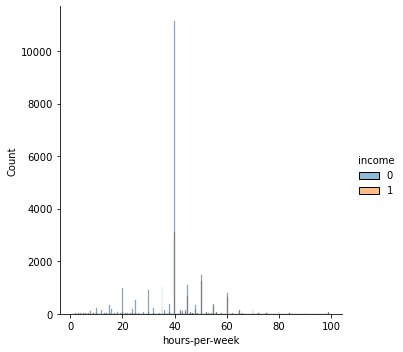

In [9]:
sns.displot(df_graph,x="hours-per-week",hue="income", kind='kde')
sns.displot(df_graph,x="hours-per-week",hue="income")

**Marital-Status:** A proportional plot was used to for martial-status. The propportional plot provides the percentage of responses that are greater than \$50k (true) as opposed to less than \$50k (false). We've added a stacked bar chart with count along side the proportional chart. The stacked bar chart is helpful, but due to the size of one category, married-civ-spouse in this case, the other counts are almost invisible. The proportion chart enables the observation of each category to understand it's impact on the response. The initial logistic regression found that if a person is a married civilian spouse, the estimated odds of having an income greater than \$50k is .03% higher than someone who is not a married civilian spouse.

<AxesSubplot:xlabel='marital-status'>

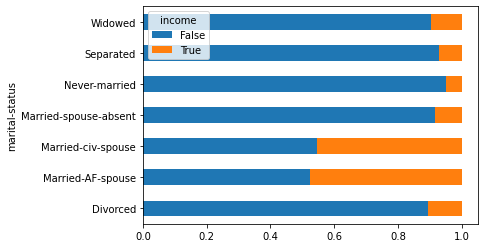

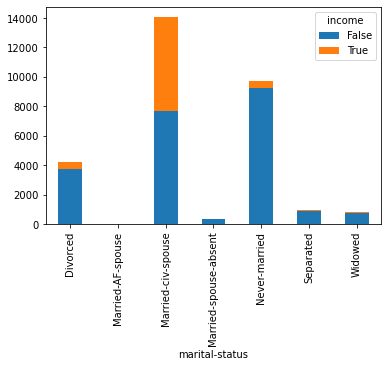

In [10]:
income_marital = pd.crosstab([df_graph['marital-status'] ], df_graph.income.astype(bool))
marital_rate = income_marital.div(income_marital.sum(1).astype(float),axis=0)
marital_rate.plot(kind='barh', stacked=True)

income_marital.plot(kind='bar', stacked=True)

**Relationship:** Continuing to leverage the proporation plot for the categorical variables, this plot shows a clear separation between Husband/Wife and the other categories. The Husband and Wife category have more than 40\% responses for greater than \$50k.

<AxesSubplot:ylabel='relationship'>

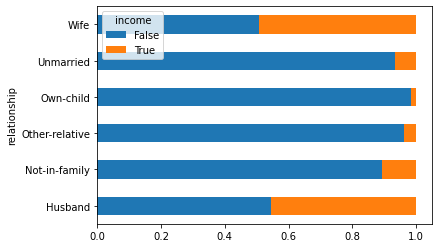

In [11]:
income_relationship = pd.crosstab([df_graph['relationship'] ], df_graph.income.astype(bool))
relationship_rate = income_relationship.div(income_relationship.sum(1).astype(float),axis=0)
relationship_rate.plot(kind='barh', stacked=True)

## Modeling and Evaluation
*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.*
 

### Association Rule Mining
 - Create frequent itemsets and association rules.
 - Use tables/visualization to discuss the found results.
 - Use several measure for evaluating how interesting different rules are.
 - Describe your results. What findings are the most compelling and why? 

#### Step One
We begin with a brute force approach to get an initial impression of our dataset. The support is initially set at .5 and confidence at .8 to explore relationships within the dataframe. The maxlen is initially set at 10 to reduce computational load, since this approach can be computationally intensive. 

In [12]:
# run apriori on dataframe
%R -i df rules <- apriori(df,parameter = list(minlen=2, maxlen=10, supp=0.5, conf=0.8))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.5      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 15081 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[107 item(s), 30162 transaction(s)] done [0.04s].
sorting and recoding items ... [7 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [15 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


<rpy2.robjects.methods.RS4 object at 0x12113dac0> [RTYPES.S4SXP]
R classes: ('rules',)

#### Step Two
Next we will look at the itemsets and rules to see how they rank by lift given the parameters that we have assigned. Lift is the predicted rate divided by the average rate. 

In [13]:
#looking at the top rules
%R inspect(head(rules, n = 100, by = "lift"))

     lhs                                rhs                              support confidence  coverage      lift count
[1]  {sex=Male,                                                                                                      
      native-country=United-States}  => {race=White}                   0.5585836  0.9071721 0.6157417 1.0551083 16848
[2]  {sex=Male}                      => {race=White}                   0.5980373  0.8850834 0.6756846 1.0294176 18038
[3]  {race=White,                                                                                                    
      sex=Male}                      => {native-country=United-States} 0.5585836  0.9340282 0.5980373 1.0242931 16848
[4]  {race=White}                    => {native-country=United-States} 0.8029308  0.9338680 0.8597905 1.0241175 24218
[5]  {native-country=United-States}  => {race=White}                   0.8029308  0.8805265 0.9118759 1.0241175 24218
[6]  {workclass=Private,                                

From this we see that there are only 15 rules that were produced using these initial parameters. We see those 15 rules ordered by the highest to lowest lift. These rules seem to highlight the large number of 'sex=Males', 'race=White', or 'native-country=United-States' are represented in this dataset. 

#### Step Three
Next we will expand our parameters to be more inclusive, since this iteration does not address our question of interest. After reviewing the list of rules above, we have decided to begin with lowering the confidence to .5 from .8 and the support to .1 from .5. This will allow for more opportunities for income to show up on the right hand side in our rules list since we are lowering the threshold of the frequency these items need to appear in the 'transactions' before being included in our rules list. 


In [14]:
# run apriori on dataframe
%R -i df rules <- apriori(df,parameter = list(minlen=1, supp=0.1, conf=0.5))

#looking at the top 100 rules
%R inspect(head(rules, n = 15, by = "lift"))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 3016 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[107 item(s), 30162 transaction(s)] done [0.04s].
sorting and recoding items ... [28 item(s)] done [0.01s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 done [0.04s].
writing ... [3293 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].
     lhs                                     rhs                              support confidence  coverage     lift count
[1]  {workclass=Private,                                                                                                 
      relationship=Own-child,   

#### Step Four

We are still getting rules that do not address our question of interest. Therefore, we will begin filtering with the income attribute values on the rhs. 

In [15]:
## find only itemsets with income attribute in the right-hand-side.
# from https://cran.r-project.org/web/packages/arules/arules.pdf 
%R rules <- apriori(df, parameter = list(minlen=2, supp=0.05, conf=0.05), appearance = list(rhs = c("income=over50K", "income=under50K")))
%R inspect(head(rules))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.05    0.1    1 none FALSE            TRUE       5    0.05      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 1508 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[107 item(s), 30162 transaction(s)] done [0.03s].
sorting and recoding items ... [34 item(s)] done [0.01s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 8 done [0.07s].
writing ... [1550 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].
    lhs                               rhs               support    confidence
[1] {occupation=Machine-op-inspct} => {income=under50K} 0.05705855 0.8753815 
[2] {workclass=Self-emp-not-inc}   => {income=under50K} 0.05918043 0.7142857 
[3] {race=Black}                   => {i

,lhs,,rhs,support,confidence,coverage,lift,count
[1],{occupation=Machine-op-inspct},=>,{income=under50K},0.057059,0.875381,0.065181,1.165501,1721
[2],{workclass=Self-emp-not-inc},=>,{income=under50K},0.059180,0.714286,0.082853,0.951015,1785
[3],{race=Black},=>,{income=under50K},0.081261,0.870075,0.093396,1.158435,2451
[4],{relationship=Unmarried},=>,{income=under50K},0.099430,0.933686,0.106492,1.243129,2999
[5],{occupation=Other-service},=>,{income=under50K},0.102115,0.958904,0.106492,1.276705,3080
[6],{occupation=Sales},=>,{income=under50K},0.086665,0.729353,0.118825,0.971075,2614


## Deployment
 - Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
 - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
 - How would your deploy your model for interested parties?
 - What other data should be collected?
 - How often would the model need to be updated, etc.? 

Association Rule Mining provided results that were not intended. First, the model resulted in 'rules' that were not associated with income, the goal of the study. After adjusting criteria in attempt to gain information about income specifically, the results provided information in relation to individuals whose income is less than \$50k. Since the goal of this study was to assess whether an individual makes *more than* \$50k, the model may be rendered incomplete. 

However, income as a binary response, provides information about the opposite category, greater than \$50k. For example, the variables with the highest lift in relation to an individual who makes *less than* \$50k, are Occupation-Other_Service, Occupation-Machine_Op_Inspct, and Relationship-unmarried. Therefore, it is reasonable to assume that factors important in predicting whether an individual makes *more than* \$50k, would be the opposite categories contained in Occupation and Relationship. 

For parties interested in understanding the demographics of individuals with an income less than \$50k, this model could be deployed for prediction purposes. However, if the same party is interested in individuals whose income is greater than \$50k, this model would be inconclusive. 

Since U.S. Census data is collected every 10 years, this model would need to be updated just as often. However, with such a large span of time between updated data, this model is prone to additional prediction errors since market conditions and employment status are subject to change more frequently than data would be made available. 

## Exceptional Work

### Exceptional Work: Cluster Analysis

 - Perform cluster analysis using several clustering methods
 - How did you determine a suitable number of clusters for each method?
 - Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
 - Describe your results. What findings are the most interesting and why? 


#### Kmeans Cluster Analysis

In [18]:
#data prep
df = pd.read_csv('https://raw.githubusercontent.com/ShelbyP27/DS7331-Project/main/adult-data.csv')

#Cleaning up dataset by removing na values & creating one-hot response
df = df.replace(to_replace='?',value=np.nan) # replace '?' with NaN (not a number)
df.dropna(inplace=True) # Removing na values
df.duplicated(subset=None, keep='first') #Remove duplicates

#change value for income to include non-mathematic notation
df['income'] = df['income'].replace(['<=50K'],'under50K')
df['income'] = df['income'].replace(['>50K'],'over50K')
df['income'] = df['income'].map({'under50K': 0, 'over50K': 1}).astype(int)

#remove attributes
del df['education-num']
del df['fnlwgt']
del df['capital-gain']
del df['capital-loss']

# One-hot encoding the Categorical variables
if 'sex' in df:
    df['IsMale'] = df.sex == 'Male'
    df.IsMale = df.IsMale.astype(np.int64)
    del df['sex']
    
if 'marital-status' in df:
    tmp_df = pd.get_dummies(df['marital-status'], prefix = 'Marital')
    df = pd.concat((df, tmp_df), axis =1)
    del df['marital-status']
    
if'relationship' in df:
    tmp_df = pd.get_dummies(df['relationship'], prefix = 'Rel')
    df = pd.concat((df, tmp_df), axis =1)
    del df['relationship']

if 'race' in df:
    tmp_df = pd.get_dummies(df['race'], prefix = 'Race')
    df = pd.concat((df, tmp_df), axis =1)
    del df['race']

if 'workclass' in df:
    tmp_df = pd.get_dummies(df['workclass'], prefix = 'Work')
    df = pd.concat((df, tmp_df), axis =1)
    del df['workclass']

if 'occupation' in df:
    tmp_df = pd.get_dummies(df['occupation'], prefix = 'Occupation')
    df = pd.concat((df, tmp_df), axis =1)
    del df['occupation']

if 'education' in df:
    tmp_df = pd.get_dummies(df['education'], prefix = 'Education')
    df = pd.concat((df, tmp_df), axis =1)
    del df['education']

    
#Replace Native Country with Immigrant atribute
if 'native-country' in df:
    df['immigrant'] = np.where(df['native-country']!= 'United-States', 1, 0)
    del df['native-country']



In [20]:
# Separating the features from the response
if 'income' in df:
    y = df['income'].values
    del df['income']
    X = df.values

# Train / Test split with scaled_X
scaled_X = StandardScaler().fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size = .2, random_state=1)

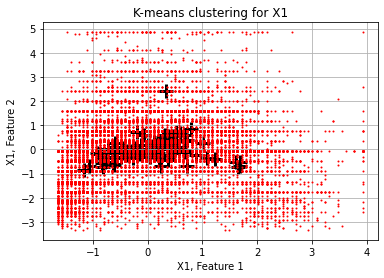

In [21]:
#kmeans
X = scaled_X

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=100,  # number of clusters
        n_init=5)       # number of different times to run k-means
       
kmeans.fit(X)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

Time for BatchKMeans:
CPU times: user 850 ms, sys: 38.9 ms, total: 889 ms
Wall time: 1.07 s
Time for MiniBatchKMeans:
CPU times: user 164 ms, sys: 25.4 ms, total: 190 ms
Wall time: 74.9 ms


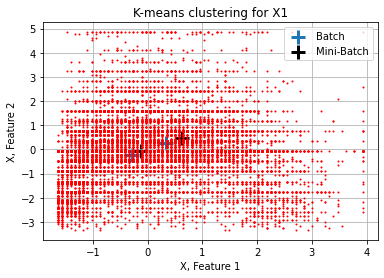

In [23]:
from sklearn.cluster import MiniBatchKMeans

kmeans_mini = MiniBatchKMeans(n_clusters=2, batch_size=1000)
kmeans = KMeans(n_clusters=2)

print('Time for BatchKMeans:')
%time kmeans.fit(X)
print('Time for MiniBatchKMeans:')
%time kmeans_mini.fit(X)


# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('X, Feature 1')
plt.ylabel('X, Feature 2')
plt.grid()
plt.show()

In [25]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
X2 = X

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 5000

#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.show()